Quick and VERY dirty mask-generation >.>

In [1]:
import torch
import torchvision
from torchvision.transforms import transforms as transforms
import numpy as np
import cv2
import random
import time
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import seaborn_image as isns
from PIL import Image
from typing import Dict, Tuple

In [2]:
coco_names = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


In [3]:
image_paths = [ "img/0001.jpg", "img/0108.jpg", "img/0115.jpg", "img/0150.jpg"]
threshold = 0.965

In [4]:
# this will help us create a different color for each class
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))

In [5]:
def get_outputs(image, model, threshold):
    with torch.no_grad():
        # forward pass of the image through the model
        outputs = model(image)
    
    # get all the scores
    scores = list(outputs[0]['scores'].detach().cpu().numpy())
    # index of those scores which are above a certain threshold
    thresholded_preds_inidices = [scores.index(i) for i in scores if i > threshold]
    thresholded_preds_count = len(thresholded_preds_inidices)
    # get the masks
    masks = (outputs[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    # discard masks for objects which are below threshold
    masks = masks[:thresholded_preds_count]
    # get the bounding boxes, in (x1, y1), (x2, y2) format
    boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))]  for i in outputs[0]['boxes'].detach().cpu()]
    # discard bounding boxes below threshold value
    boxes = boxes[:thresholded_preds_count]
    # get the classes labels
    labels = [coco_names[i] for i in outputs[0]['labels']]
    return masks, boxes, labels

In [6]:
def create_mask(image, masks, boxes, labels):
    alpha = 1 
    beta = 0.6 # transparency for the segmentation map
    gamma = 0 # scalar added to each sum
    w, h = image.size
    #Might not be needed
    segmentation_map = np.zeros((h,w,3))
    
    for i in range(len(masks)):
        if labels[i] == 'person':
            #can we clean this more up?
            red_map = np.zeros_like(masks[i]).astype(np.uint8)
            green_map = np.zeros_like(masks[i]).astype(np.uint8)
            blue_map = np.zeros_like(masks[i]).astype(np.uint8)
            color = (255,255,255)
            red_map[masks[i] == 1], green_map[masks[i] == 1], blue_map[masks[i] == 1]  = color
            segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
            
    return segmentation_map



In [7]:
# initialize the model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, progress=True, 
                                                           num_classes=91)
# set the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# load the modle on to the computation device and set to eval mode
model.to(device).eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [8]:
# transform to convert the image to tensor
transform = transforms.Compose([
    transforms.ToTensor()
])

In [9]:
masked_images = []
for img_path in image_paths:
    image = Image.open(img_path)
    # keep a copy of the original image for OpenCV functions and applying masks
    orig_image = image.copy()
    # transform the image
    image = transform(image)
    # add a batch dimension
    image = image.unsqueeze(0).to(device)
    a = time.time()
    masks, boxes, labels = get_outputs(image, model, threshold)
    output_img = create_mask(orig_image, masks, boxes, labels)
    masked_images.append(output_img)
    
    

/Users/nea/miniconda3/envs/work-env/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1639180852547/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


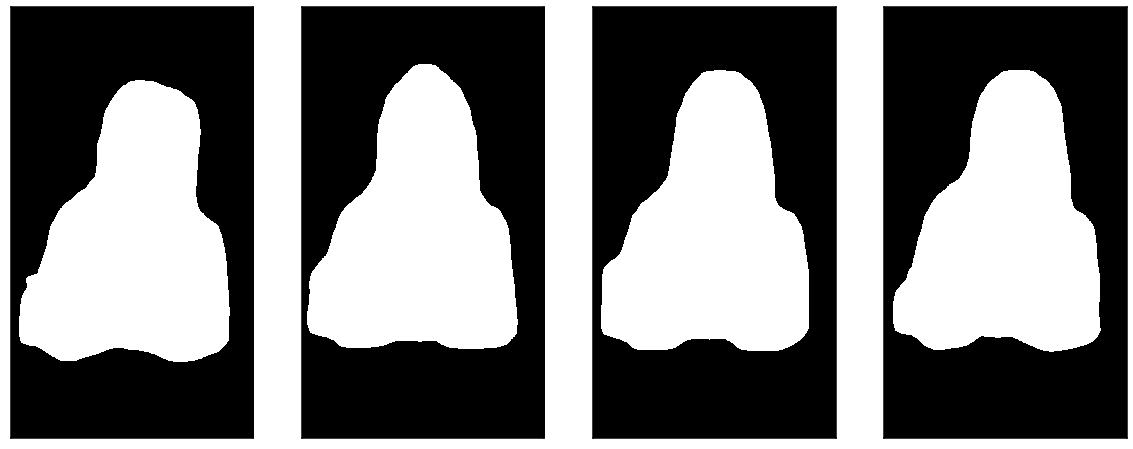

In [10]:
xlen = len(masked_images)
fig, axes = plt.subplots(1, xlen)
fig.set_size_inches(20,10)
for ax, img in zip(axes, masked_images):
    isns.imgplot(img, ax=ax, cbar=False)
    ax.invert_yaxis()

In [11]:
image = Image.open("img/0001.jpg")
w, h = image.size
result = np.zeros((h,w,3))
for mask in masked_images:
    result = cv2.add(result, mask,dtype=cv2.CV_64F)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


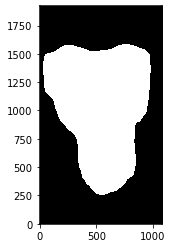

In [12]:
#Ik is heads-down but really no time to fix this rn, we wont need it anyway
plt.imshow(result)